In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
%matplotlib inline
import warnings
from copy import deepcopy
warnings.filterwarnings("ignore")

In [33]:
def loadData(data):
    df = pd.read_csv(data)

    # print(df.shape[1])

    x = df.iloc[:,:-1]
    y = df.iloc[:,-1]
    
    return x,y

In [34]:
def cat2num(y):
    for i in range(len(y)):
        if y[i] == 'dos':
            y[i] = 0
        elif y[i] == 'normal':
            y[i] = 1
        elif y[i] == 'probe':
            y[i] = 2
        elif y[i] == 'r2l':
            y[i] = 3
        else:
            y[i] = 4
    return y

In [35]:
def PCA(x,D):
    
    mu = np.mean(x, axis=0)
    cov = ( ((x - mu).T).dot(x - mu) ) / (x.shape[0]-1)
#     print('Covariance matrix \n%s' %cov)

    eigenVal, eigenVec = np.linalg.eig(cov)
#     print('Eigenvectors \n%s' %eigenVec)
#     print('\nEigenvalues \n%s' %eigenVal)
    
    eList = []
    for i in range(len(eigenVal)):
        eList.append((np.abs(eigenVal[i]), eigenVec[:,i]))
#     print(eList)

    eList.sort(key=lambda x:x[0])
    eList.reverse()

#     print('Eigenvalues in descending order:')
#     for i in eList:
#         print(i[0])
    
    eSum = sum(eigenVal)
    eVar = []
    for i in sorted(eigenVal, reverse=True):
        eVar.append((i / eSum)*100)
    
    eVar = np.abs(np.cumsum(eVar))
#     print(eVar)

    # Calculating the index of first eigen value, upto which error is <10%
    if D == 1:
        index = next(x[0] for x in enumerate(eVar) if x[1] > 90)
    else:
        index = 1
    print('Number of eigen values selected to maintain threshold at 10% is:',index+1)
    print('')
    
    w = eList[0][1].reshape(len(eigenVec),1)
    for i in range(1,index+1):
        w = np.hstack((w, eList[i][1].reshape(len(eigenVec),1))) #Concatinating Eigen Vectors column wise to form W matrix
#     print('Matrix W:\n', w)
#     print(w.shape)

    x_reduced = x.dot(w)
    print('PCA Reduced Data')
    print('')
    print(x_reduced)
    print('')
    
    return x_reduced
    

In [36]:
def dist(a, b):
    return np.linalg.norm(a - b, axis=1)

In [37]:
def cal_purity(labels,y):
    cnf_matrix = np.zeros((5,5))
    for i in range(len(y)):
                cnf_matrix[int(labels[i]),y[i]] +=1 
    num = 0
    for i in range(5):
        num += np.max(cnf_matrix[i]) 
    return (num/len(y))

In [38]:
def kmeans(x_reduced,y,k,D):
    
    centroid= np.random.randint(0, np.max(x_reduced), size=k)
    centroid = centroid.reshape(k,1)
    for i in range (1,x_reduced.shape[1]):    
        centroid_i = np.random.randint(0, np.max(x_reduced), size=k)  #Generate random values between 0 and max(x)-20 of k dimention
        centroid_i = centroid_i.reshape(k,1)
        centroid = np.hstack((centroid,centroid_i))
        
    print("Clustering Started !!!")
    print('')
    print("Initial Centroids Set to:")
    print(centroid)
    print('')

    centroid_old = np.zeros(centroid.shape)
    clusters = np.zeros(len(x_reduced))
    error_dist = dist(centroid, centroid_old)    

    while np.count_nonzero(error_dist) != 0:  #Iterate until there is no change in centroid position
        
        for i in range(len(x_reduced)):  # Labelling each point w.r.t its nearest cluster
            distances = dist(x_reduced[i], centroid)
            cluster = np.argmin(distances)
            clusters[i] = cluster
        
        centroid_old = deepcopy(centroid)
        for i in range(k): #New centroid will be the average of the distances
            points = [x_reduced[j] for j in range(len(x_reduced)) if clusters[j] == i]  #All the points which are under ith cluster as per current clustering
            centroid[i] = np.mean(points, axis=0)
        error_dist = dist(centroid, centroid_old)
        print('Distance moved by Centroids in next interation')
        print(error_dist)
        print('')
    print('Clustering Completed !!!')
    print('')

    if D == 0: 
        color=['cyan','magenta','red','blue','green']
        labels=['cluster1','cluster2','cluster3','cluster4','cluster5']
        for i in range(k):
            points = np.array([x_reduced[j] for j in range(len(x_reduced)) if clusters[j] == i])
    #         print('Points in Cluster: ',i)
    #         print(points)
            if points.size != 0:
                plt.scatter(points[:,0],points[:,1],c=color[i],label=labels[i])
    #     plt.scatter(centroid[:,0],centroid[:,1],s=300,c='y',label='Centroids')
        plt.title('Clusters of Network Attack after reducing data to 2-D using PCA')
        plt.xlabel('Attribte 1')
        plt.ylabel('Attribute 2')
        plt.legend()
        plt.show()
    return clusters

Doing Clustering by selecting reduced number of dimentions in PCA as per threshold of 10%

Number of eigen values selected to maintain threshold at 10% is: 14

PCA Reduced Data

[[-2.50946520e+00  9.52118043e-01  8.05755168e-02 ...  8.50312294e-02
  -4.78761528e-01  3.80057517e-01]
 [ 1.19325993e+00 -5.59820431e+00  2.70795585e-01 ...  6.43676015e-02
   4.30117879e-01  2.64015116e-01]
 [-2.44710014e+00  9.08939709e-01  6.03192180e-02 ...  5.04823140e-02
  -7.54360905e-01  4.29615250e-01]
 ...
 [-2.14676535e-01 -3.09877590e-01 -1.37272986e+01 ...  1.72825356e+01
  -1.61696242e+00  1.79863104e+00]
 [-3.46663135e+00  5.46446031e-01 -7.44319096e-02 ...  3.55261207e-01
   4.57109427e-01 -7.13572892e-01]
 [ 4.01832089e+00  1.12480793e+00 -6.01524597e-02 ... -3.89962407e-03
   2.80523132e-01  2.18831703e-01]]

Clustering Started !!!

Initial Centroids Set to:
[[ 9 23 33 23 39 39 28 28 43 49 31 51 16 15]
 [30 13 11 37  7 26 32 35 26 35 11 14 24 28]
 [22  2 35 40 51 51  7 48 52 12 12 25 27 32]


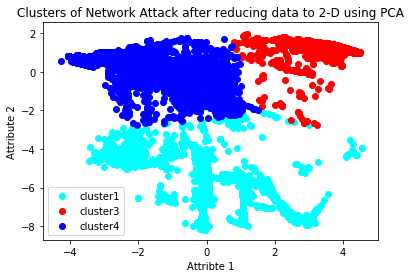


Purity while reducing data as per threshold:  0.837747019761581


In [39]:
if __name__ == '__main__':
    
    data = '../Dataset/intrusion_detection/data.csv'
    x,y = loadData(data)
    y = cat2num(y)
    x = StandardScaler().fit_transform(x)
    
    print('Doing Clustering by selecting reduced number of dimentions in PCA as per threshold of 10%')
    print('')
    x_reduced = PCA(x,1)    
    clusters1 = kmeans(x_reduced,y,5,1)
    purity1 = cal_purity(clusters1,y)
    print('Purity while reducing data as per threshold: ', purity1)

    print('')
    print('')
    
    print('Doing Clustering by selecting reduced number of dimentions in PCA as 2 for getting plots')
    print('')
    x_reduced = PCA(x,0)    
    clusters2 = kmeans(x_reduced,y,5,0)
    purity2 = cal_purity(clusters2,y)
    print('')
    print('Purity while reducing data as per threshold: ', purity2)

In [41]:
print(x_reduced.shape)

(24998, 2)


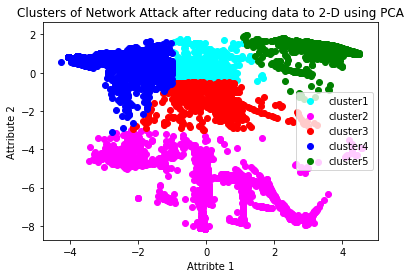